## Carga de datos desde el dataset alerceZTFv7.1

In [1]:
import numpy as np
import pandas as pd

survey_name = 'alerceZTFv7.1' # use this dataset
### load files
load_root_dir = f'./data/{survey_name}'
labels_df = pd.read_parquet(f'{load_root_dir}/labels_vs.parquet')
print(f'labels_df; columns={list(labels_df.columns)}; id={labels_df.index.name}')
detections_df = pd.read_parquet(f'{load_root_dir}/detections_vs.parquet')
print(f'detections_df; columns={list(detections_df.columns)}; id={detections_df.index.name}')

### print info
classes = sorted(set(labels_df['classALeRCE'].values))
print(f'classes={classes}')

labels_df; columns=['classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source', 'class_source', 'separation_arcsec']; id=oid
detections_df; columns=['fid', 'mjd', 'magpsf_corr', 'sigmapsf_corr']; id=oid
classes=['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL']


In [27]:
detections_df

,fid,mjd,magpsf_corr,sigmapsf_corr
oid,,,,
ZTF17aaafyya,1,58791.283368,15.262989,0.004987
ZTF17aaafyya,1,59081.470544,15.281165,0.007919
ZTF17aaafyya,1,59067.403970,15.245437,0.000493
ZTF17aaafyya,1,58793.249965,15.205705,0.010043
ZTF17aaafyya,1,58793.239028,15.228786,0.009911
...,...,...,...,...
ZTF20abceckn,1,58976.471597,17.589780,0.036465
ZTF20abceckn,2,58998.320336,17.600946,0.013244
ZTF20abceckn,2,58986.296597,17.655712,0.017770


#### Cambio de nombre de las columnas de las detecciones para posterior extracción de features

In [2]:
detections_df = detections_df.rename(columns={'fid' : 'band', 'mjd': 'time', 'magpsf_corr': 'magnitude', 'sigmapsf_corr': 'error'})
detections_df

,band,time,magnitude,error
oid,,,,
ZTF17aaafyya,1,58791.283368,15.262989,0.004987
ZTF17aaafyya,1,59081.470544,15.281165,0.007919
ZTF17aaafyya,1,59067.403970,15.245437,0.000493
ZTF17aaafyya,1,58793.249965,15.205705,0.010043
ZTF17aaafyya,1,58793.239028,15.228786,0.009911
...,...,...,...,...
ZTF20abceckn,1,58976.471597,17.589780,0.036465
ZTF20abceckn,2,58998.320336,17.600946,0.013244
ZTF20abceckn,2,58986.296597,17.655712,0.017770


In [31]:
labels_df

,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
oid,,,,,,,,
ZTF18abwwdsc,Ceph,326.755845,-8.060673,2.18895,CRTSnorth,1007116010622.0,Cep-II,0.676851
ZTF18aaakigd,Ceph,65.440016,34.069809,2.11360,CRTSnorth,1135020009815.0,ACEP,0.390734
ZTF18aaavkyj,Ceph,192.885044,24.122642,1.09572,CRTSnorth,1123064031941.0,ACEP,0.291110
ZTF18abwwdxw,Ceph,324.865973,-17.296145,1.11714,CRTSnorth,1018112055304.0,ACEP,1.881608
ZTF19aaocniv,Ceph,248.580619,-16.015739,1.3049582,CRTSnorth,1015086048064.0,Cep-II,0.405458
...,...,...,...,...,...,...,...,...
ZTF18aaxymzx,LPV,295.919157,22.724404,None,GAIADR2VS,2.0199127469765652e+18,MIRA_SR,0.299388
ZTF18abikbvc,LPV,286.720222,24.733440,None,GAIADR2VS,4.533629080944307e+18,MIRA_SR,0.299487
ZTF19aamtoyb,LPV,99.257590,-15.567786,None,GAIADR2VS,2.9501070744892713e+18,MIRA_SR,0.299597


#### Visualización del desbalance de clases

In [24]:
%load_ext autoreload
%autoreload 2
from fuzzytools.level_bars import LevelBar

classes, counts = np.unique(labels_df['classALeRCE'].values, return_counts=True)
population_cdict = {c:counts[kc] for kc,c in enumerate(classes)}
print(LevelBar(population_cdict, ncols=60))

|▍                                                         | Ceph - 665/82,237 (0.81%)
|▌                                                         | DSCT - 804/82,237 (0.98%)
|███████████████████████▏                                  | EB/EW - 32,825/82,237 (39.92%)
|█████████▍                                                | LPV - 13,403/82,237 (16.30%)
|████████████████████████▎                                 | RRL - 34,540/82,237 (42.00%)



## Extracción de features

In [3]:
from lc_classifier.features import MHPSExtractor, PeriodExtractor, GPDRWExtractor
from lc_classifier.features import FoldedKimExtractor
from lc_classifier.features import HarmonicsExtractor, IQRExtractor
from lc_classifier.features import PowerRateExtractor
from lc_classifier.features import TurboFatsFeatureExtractor

from lc_classifier.features import FeatureExtractorComposer

In [4]:
# feature extractor parameters
bands = [1, 2] # 1=g, 2=r 
true_period = 0.37
smallest_period = 1/1000
largest_period = 1/20.0
optimal_grid = False
trim_lightcurve_to_n_days = None
min_length = 5

In [ ]:
# Compose feature extractors
feature_extractor = FeatureExtractorComposer(
    [
        MHPSExtractor(bands),
        PeriodExtractor(bands,smallest_period,largest_period,optimal_grid,trim_lightcurve_to_n_days,min_length,),
        GPDRWExtractor(bands),
        FoldedKimExtractor(bands),
        HarmonicsExtractor(bands),
        IQRExtractor(bands),
        PowerRateExtractor(bands),
        TurboFatsFeatureExtractor(bands)
    ]
)

# FATS (Feature Analysis for Time Series) feature extractor
fats_feature_extractor = TurboFatsFeatureExtractor(bands)

#### Extracción de features de las curvas de luz usando FATS

In [ ]:
features = fats_feature_extractor.compute_features(detections_df)
features

In [34]:
features.to_parquet('FATS_features.parquet') # save features

#### Eliminación de valores NaN

In [49]:
features = features.dropna() # drop rows with NaN values
features.to_parquet('FATS_features_no_nan.parquet') # save features
features

,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Mean_1,Meanvariance_1,...,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaasi,1.242288,1.000000,23.0,0.504348,0.000000,0.002255,-0.631776,9.273054,16.933660,0.048435,...,-0.302912,-1.191929,0.518378,0.712563,1.000000,1.342675e-03,1.521999,0.519184,9.974179e-01,0.007309
ZTF17aaaaast,0.191213,0.938206,5.0,0.366337,0.000000,0.108245,0.029446,7.469771,18.573058,0.006267,...,0.339512,-0.681677,0.115633,0.754857,1.000000,5.762749e-05,0.344765,0.308382,9.646053e-01,0.000022
ZTF17aaaaasx,0.301579,0.363988,3.0,0.370370,0.000000,0.128569,-0.132999,0.117722,18.769707,0.008946,...,0.639895,-0.341089,0.131880,0.769824,1.000000,7.010388e-05,0.631177,0.536813,9.761962e-01,-0.000029
ZTF17aaaaatf,2.314933,0.980362,1.0,0.187500,0.000000,0.000065,2.857780,0.824873,16.258839,0.076111,...,0.963794,0.509305,1.229924,0.771884,1.000000,7.472222e-03,4.080633,0.537388,9.904864e-01,-0.000768
ZTF17aaaaavq,1.614371,0.999778,14.0,0.354740,0.003077,0.005771,0.138534,433.547581,16.989377,0.050640,...,-0.156749,-0.437088,0.563447,0.693467,1.000000,1.537455e-03,1.346824,0.342845,9.882553e-01,0.001038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20abaomtv,0.028262,0.391988,1.0,0.166667,0.000000,0.184737,0.014949,0.007573,14.158186,0.001371,...,0.257970,-0.089280,0.031752,0.920866,1.000000,4.730070e-06,0.024404,-0.103199,5.281057e-13,-0.000095
ZTF20abaqokb,0.023181,0.412205,2.0,0.500000,0.000000,3.298927,0.000106,0.034626,18.540150,0.000895,...,-0.494583,0.402274,0.018447,0.894136,0.514827,-7.790357e-07,-0.500000,-0.500000,4.230063e-13,-0.000951
ZTF20abasbbs,0.081146,0.410671,1.0,0.363636,0.000000,0.353141,-0.019145,0.669897,18.142770,0.002963,...,-0.070178,-1.302598,0.046700,0.840171,1.000000,6.569412e-06,0.067511,0.017920,6.494115e-01,-0.000227


### Unión de features y clases

In [57]:
merged_data = pd.merge(features, labels_df.loc[:, ['classALeRCE']], on='oid') # merge features with labels
merged_data.to_parquet('FATS_features_with_labels.parquet') # save features with labels
merged_data

,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Mean_1,Meanvariance_1,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaasi,1.242288,1.000000,23.0,0.504348,0.000000,0.002255,-0.631776,9.273054,16.933660,0.048435,...,-1.191929,0.518378,0.712563,1.000000,1.342675e-03,1.521999,0.519184,9.974179e-01,0.007309,LPV
ZTF17aaaaast,0.191213,0.938206,5.0,0.366337,0.000000,0.108245,0.029446,7.469771,18.573058,0.006267,...,-0.681677,0.115633,0.754857,1.000000,5.762749e-05,0.344765,0.308382,9.646053e-01,0.000022,LPV
ZTF17aaaaasx,0.301579,0.363988,3.0,0.370370,0.000000,0.128569,-0.132999,0.117722,18.769707,0.008946,...,-0.341089,0.131880,0.769824,1.000000,7.010388e-05,0.631177,0.536813,9.761962e-01,-0.000029,LPV
ZTF17aaaaatf,2.314933,0.980362,1.0,0.187500,0.000000,0.000065,2.857780,0.824873,16.258839,0.076111,...,0.509305,1.229924,0.771884,1.000000,7.472222e-03,4.080633,0.537388,9.904864e-01,-0.000768,LPV
ZTF17aaaaavq,1.614371,0.999778,14.0,0.354740,0.003077,0.005771,0.138534,433.547581,16.989377,0.050640,...,-0.437088,0.563447,0.693467,1.000000,1.537455e-03,1.346824,0.342845,9.882553e-01,0.001038,LPV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20abaomtv,0.028262,0.391988,1.0,0.166667,0.000000,0.184737,0.014949,0.007573,14.158186,0.001371,...,-0.089280,0.031752,0.920866,1.000000,4.730070e-06,0.024404,-0.103199,5.281057e-13,-0.000095,EB/EW
ZTF20abaqokb,0.023181,0.412205,2.0,0.500000,0.000000,3.298927,0.000106,0.034626,18.540150,0.000895,...,0.402274,0.018447,0.894136,0.514827,-7.790357e-07,-0.500000,-0.500000,4.230063e-13,-0.000951,EB/EW
ZTF20abasbbs,0.081146,0.410671,1.0,0.363636,0.000000,0.353141,-0.019145,0.669897,18.142770,0.002963,...,-1.302598,0.046700,0.840171,1.000000,6.569412e-06,0.067511,0.017920,6.494115e-01,-0.000227,EB/EW


## Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data into a Pandas dataframe
df = pd.read_parquet('data/preprocessed/FATS_features_with_labels.parquet')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('classALeRCE', axis=1), df['classALeRCE'], test_size=0.2)

# Create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Evaluate the model on the testing data
score = rf.score(X_test, y_test)
print('Accuracy:', score)

/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

Accuracy: 0.9178714241771763


/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

In [79]:
y_test.value_counts()

classALeRCE
RRL      3798
EB/EW    1470
LPV      1145
DSCT       51
Ceph       38
Name: count, dtype: int64

/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

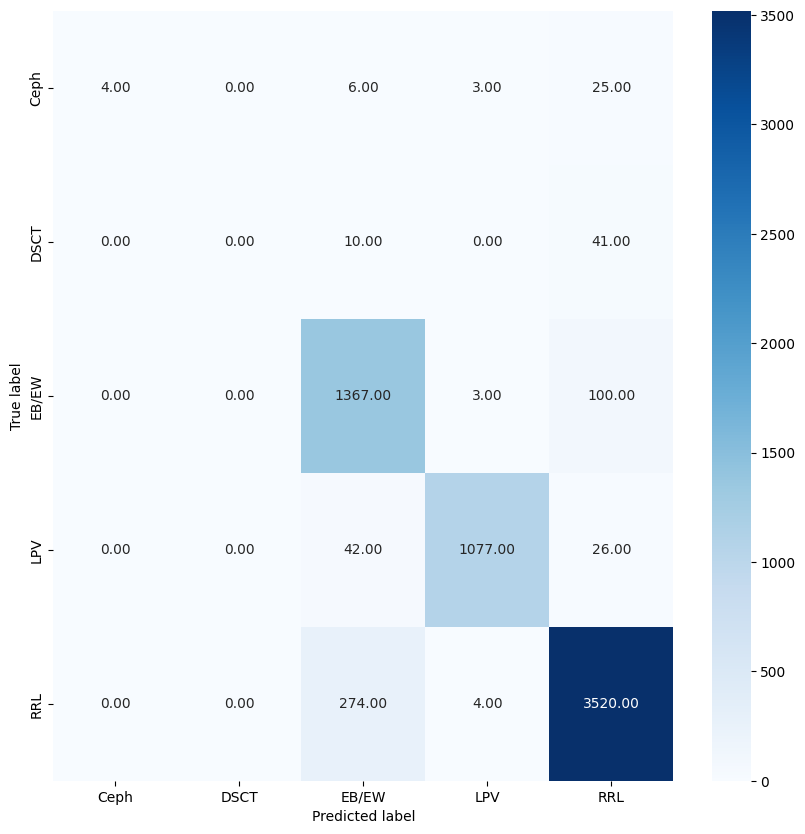

In [85]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # correct order

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Balanced Random Forest

In [86]:
# balanced random forest
from imblearn.ensemble import BalancedRandomForestClassifier

# Create a random forest classifier with 100 trees
brf = BalancedRandomForestClassifier(n_estimators=100)

# Fit the model to the training data
brf.fit(X_train, y_train)

# Evaluate the model on the testing data
score = brf.score(X_test, y_test)
print('Accuracy:', score)

/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/

Accuracy: 0.7366964011073516


/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/mnt/c/Users/alvar/OneDrive - Universidad de Chile/Documentos/U/11o Semestre/EL4106 Inteligencia Computacional/Proyecto/projwsl/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

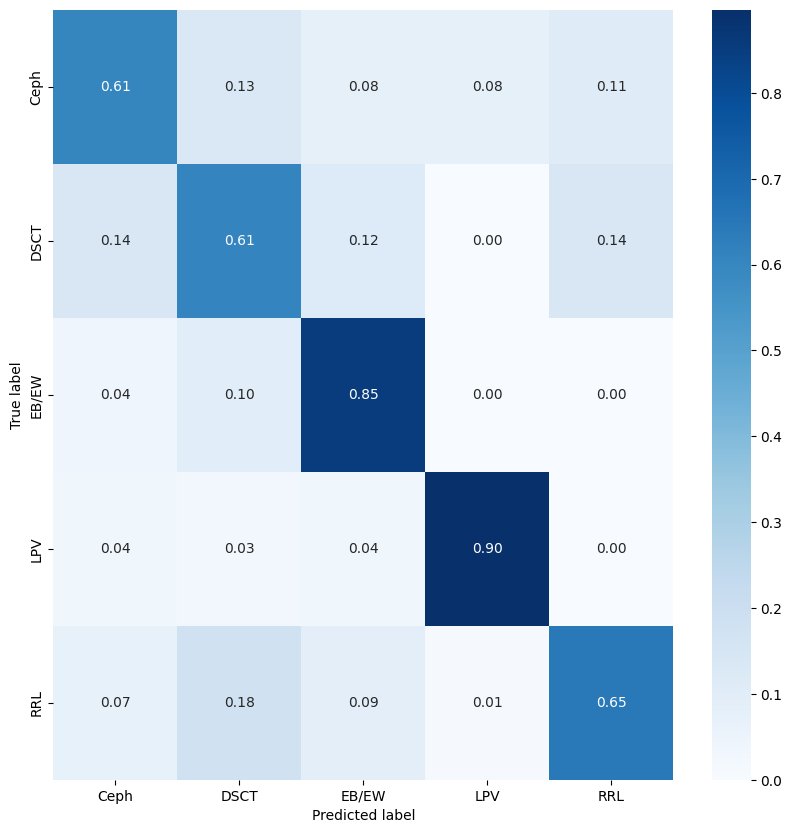

In [90]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # correct order

y_pred = brf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
